In [50]:
import pyaudio
import struct #converts binary strings to integers
import matplotlib.pyplot as plt
import numpy as np
from aubio import pitch
from math import log2, pow

#inline backend to display matplotlib plots on new screen
%matplotlib inline

In [51]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 5

In [52]:
A4 = 440
C0 = A4 * pow(2, -4.75)
name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def pitch_to_note(freq):
    h = round(12 * log2(freq / C0))
    octave = int(h // 12)
    n = int(h % 12)
    return name[n] + str(octave)

In [53]:
p = pyaudio.PyAudio() # object of class pyaudio.PyAudio is instantiated
                      # starts PortAudio

# open an audio stream
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)
# frames per buffer is the length of the audio buffer

# use stream callback
print("* recording")

squarer = lambda t: t ** 2
square = np.vectorize(squarer)

data_int = []
data_odf = []
thresholds = [0]

onsets_y = []
onsets_x = []
alpha = 5
beta = 5
m = 20
RECORD_SECONDS = 10

tolerance = 0.3
win_s = 1024
hop_s = 1024
pitch_o = pitch("yin", win_s, hop_s, RATE)
pitch_o.set_tolerance(tolerance)

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)): 
    data = np.frombuffer(stream.read(CHUNK), dtype=np.int16)
    data_int = np.concatenate((data_int, data))
    data_energy_value = np.sum(square(data))
    if i > 0:
        data_odf.append(abs(data_energy_value - data_energy_value_previous))
    else:
        data_odf.append(data_energy_value)
    data_energy_value_previous = data_energy_value
    if i >= m:
        data_odf_previous_m_median = np.median(data_odf[i-m:i])
        data_odf_previous_m_mean = np.mean(data_odf[i-m:i])
        thresholds.append((beta * data_odf_previous_m_median) + (alpha * data_odf_previous_m_mean))
    elif i > 0:
        data_odf_previous_m_median = np.median(data_odf[0:i])
        data_odf_previous_m_mean = np.mean(data_odf[0:i])
        thresholds.append((beta * data_odf_previous_m_median) + (alpha * data_odf_previous_m_mean))
    
    if i > 1:
        if (data_odf[i-1] > data_odf[i] and data_odf[i-1] > data_odf[i-2]):
            if (data_odf[i-1] > thresholds[i-1]):
                onsets_y.append(data_odf[i-1])
                onsets_x.append(i-1)
                print("Onset Detected")
                float_data = data.astype(np.float32) 
                pitch_1 = pitch_o(float_data)[0]
                print("Frequency: ", pitch_1)
                if pitch_1 > 0:
                    note = pitch_to_note(pitch_1)
                else:
                    note = None
                print(note)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

* recording
Onset Detected
Frequency:  146.27304
D3
* done recording


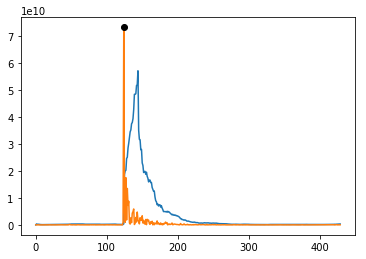

In [54]:
x_1 = np.arange(0, 430, 1)
x_2 = np.arange(0, 430, 1)
plt.clf()
plt.plot(x_1, thresholds[::1])
plt.plot(x_2, data_odf[::1])
plt.plot(onsets_x, onsets_y, 'o', color='black');
plt.show()

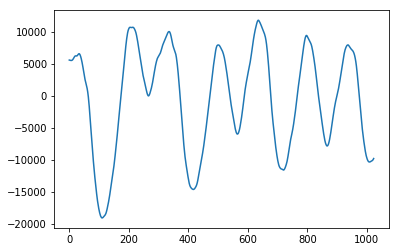

array([  5598.,   5585.,   5576., ..., -10004.,  -9918.,  -9817.],
      dtype=float32)

In [55]:
x_1 = np.arange(0, 1024, 1)
plt.clf()
plt.plot(x_1, float_data)
plt.show()
float_data